# Chap09 - 텐서플로 시작하기

## SetUp

In [1]:
import os
import numpy as np
import tensorflow as tf

# 일관된 출력을 위해 유사난수 초기화
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
sn.set()
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
# matplotlib.rc('font', family='AppleGothic')  # MacOS
matplotlib.rc('font', family='Malgun Gothic')  # Windows
plt.rcParams['axes.unicode_minus'] = False

## 9.1 Install

```bash
# TensorFlow CPU 
$ pip install tensorflow

# TensorFlow GPU
$ pip install tensorflow-gpu
```

In [2]:
import tensorflow as tf

tf.__version__

'1.10.0'

## 9.2 첫 번째 계산 그래프를 만들어 세션에서 실행하기

In [3]:
import tensorflow as tf

reset_graph()

x = tf.Variable(3, name='x')
y = tf.Variable(4, name='y')
f = x*x*y + y + 2

In [4]:
f

<tf.Tensor 'add_1:0' shape=() dtype=int32>

In [5]:
sess = tf.Session()
sess.run(x.initializer)
sess.run(y.initializer)
result = sess.run(f)
print(result)

42


In [6]:
# Session 닫기
sess.close()

위의 방법을 `with` 스코프를 이용해 간단하게 작성할 수 있다. `with` 스코프가 끝나면 `tf.Session`은 자동 종료 된다.

In [7]:
with tf.Session() as sess:
    x.initializer.run()  # tf.get_default_session().run(x.initializer)
    y.initializer.run()
    result = f.eval()  # tf.get_default_session().run(f)
    
print(result)

42


각 변수를 일일이 초기화하는 대신 `global_variables_initializer()`함수를 사용할 수 있다.

In [8]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    # 모든 변수 초기화
    init.run()  # sess.run(init)
    result = f.eval()

print(result)

42


## 9.3 계산 그래프 관리

노드를 만들면 자동으로 기본 계산 그래프에 추가된다.

In [9]:
reset_graph()

x1 = tf.constant(1)
x1.graph is tf.get_default_graph()

True

`tf.Graph()`를 이용해 새로운 독립적인 계산 그래프를 만들 수 있으며, 이를 `.as_default()`를 통해 기본 계산 그래프로 사용할 수 있다.

In [10]:
graph = tf.Graph()
with graph.as_default():
    x2 = tf.constant(2)
    print(x2.graph is tf.get_default_graph())  # True
    
print(x2.graph is tf.get_default_graph())  # False
print(x2.graph is graph)  # True

True
False
True


## 9.4 노드 값의 생애주기

> 노드는 연산, 엣지는 텐서 객체!!

텐서플로는 그래프의 연결 상태를 기반으로 연산을 최적화한다. 각 그래프에는 노드 간에 의존관계(dependency)가 존재한다. 예를 들어, 아래의 그림 'A'에서 노드 `e`는 노드 `c`에 직접의존(direct dependeny)하고 있고, 노드 `a`에는 간접의존(indirect dependency) 한다.

![](./images/graph02.png)

위의 그림에서 노드`e`를 계산하기 위해서는 노드 `c, b, a`만 계산 해주면 된다. 따라서, 의존관계를 이용해 연산량이 최소화할 수 있다. 이처럼 그래프를 통해 각 노드의 모든 의존관계를 파악할 수 있다.

In [11]:
w = tf.constant(3)
x = w + 2
y = tf.add(x, 5)
z = x * 3

with tf.Session() as sess:
    y_val, z_val = sess.run([y, z])
    print(y_val)  # 10
    print(z_val)  # 15

10
15


## 9.5 텐서플로를 이용한 선형 회귀

### 정규식을 이용한 선형 회귀 풀이

$$
\hat{\mathbf{W}} = \left(\mathbf{X}^{T} \mathbf{X} \right)^{-1} \mathbf{X}^{T} \mathbf{Y} 
$$

In [12]:
import numpy as np
from sklearn.datasets import fetch_california_housing

reset_graph()

housing = fetch_california_housing()
m, n = housing.data.shape
# bias 추가
housing_data_plus_bias = np.c_[np.ones((m, 1)), housing.data]

print('data shape :', housing.data.shape)
print('data_plus_bias shape :', housing_data_plus_bias.shape)

data shape : (20640, 8)
data_plus_bias shape : (20640, 9)


In [13]:
X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name='y')  # (20640, 1)
X_t = tf.transpose(X)
weight = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(X_t, X)), X_t), y)

with tf.Session() as sess:
    weight_val = weight.eval()
    
print(weight_val)

[[-3.7185181e+01]
 [ 4.3633747e-01]
 [ 9.3952334e-03]
 [-1.0711310e-01]
 [ 6.4479220e-01]
 [-4.0338000e-06]
 [-3.7813708e-03]
 [-4.2348403e-01]
 [-4.3721911e-01]]


### Scikit-Learn과 비교

In [14]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing.data, housing.target.reshape(-1, 1))

print(np.r_[lin_reg.intercept_.reshape(-1, 1), lin_reg.coef_.T])

[[-3.69419202e+01]
 [ 4.36693293e-01]
 [ 9.43577803e-03]
 [-1.07322041e-01]
 [ 6.45065694e-01]
 [-3.97638942e-06]
 [-3.78654265e-03]
 [-4.21314378e-01]
 [-4.34513755e-01]]


## 9.6 경사 하강법 구현

> 경사 하강법을 사용할 때는 입력 특성 벡터를 정규화(normalization)해주는 것이 중요하다. 그렇지 않으면 학습속도가 매우 느려진다. 

### StandardScaler를 이용한 정규화(normalization)

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_housing_data = scaler.fit_transform(housing.data)
scaled_housing_data_plus_bias = np.c_[np.ones((m, 1)), scaled_housing_data]

In [16]:
print(scaled_housing_data_plus_bias.mean(axis=0))
print(scaled_housing_data_plus_bias.mean(axis=1))
print(scaled_housing_data_plus_bias.mean())
print(scaled_housing_data_plus_bias.shape)

[ 1.00000000e+00  6.60969987e-17  5.50808322e-18  6.60969987e-17
 -1.06030602e-16 -1.10161664e-17  3.44255201e-18 -1.07958431e-15
 -8.52651283e-15]
[ 0.38915536  0.36424355  0.5116157  ... -0.06612179 -0.06360587
  0.01359031]
0.11111111111111005
(20640, 9)


### 9.6.1 직접 그래디언트 계산

In [17]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name='y')
W = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name='W')

y_pred = tf.matmul(X, W, name='predictions')  # y = wx + b
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name='mse')
gradients = 2/m * tf.matmul(tf.transpose(X), error)
training_op = tf.assign(W, W - learning_rate * gradients)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("epoch: {:03d}, MSE = {:.6f}".format(epoch, mse.eval()))
        sess.run(training_op)
        
    best_W = W.eval()  # sess.run(W)

print(best_W)

epoch: 000, MSE = 9.161543
epoch: 100, MSE = 0.714501
epoch: 200, MSE = 0.566705
epoch: 300, MSE = 0.555572
epoch: 400, MSE = 0.548811
epoch: 500, MSE = 0.543636
epoch: 600, MSE = 0.539629
epoch: 700, MSE = 0.536509
epoch: 800, MSE = 0.534068
epoch: 900, MSE = 0.532147
[[ 2.0685523 ]
 [ 0.8874027 ]
 [ 0.14401656]
 [-0.34770885]
 [ 0.36178368]
 [ 0.00393811]
 [-0.04269556]
 [-0.66145283]
 [-0.6375278 ]]


### 9.6.2 자동 미분 사용

In [18]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name='y')
W = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name='W')

y_pred = tf.matmul(X, W, name='predictions')  # y = wx + b
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name='mse')

# auto-gradients
gradients = tf.gradients(mse, [W])[0]
training_op = tf.assign(W, W - learning_rate * gradients)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("epoch: {:03d}, MSE = {:.6f}".format(epoch, mse.eval()))
        sess.run(training_op)
        
    best_W = W.eval()  # sess.run(W)

print(best_W)

epoch: 000, MSE = 9.161543
epoch: 100, MSE = 0.714501
epoch: 200, MSE = 0.566705
epoch: 300, MSE = 0.555572
epoch: 400, MSE = 0.548811
epoch: 500, MSE = 0.543636
epoch: 600, MSE = 0.539629
epoch: 700, MSE = 0.536509
epoch: 800, MSE = 0.534068
epoch: 900, MSE = 0.532147
[[ 2.0685525 ]
 [ 0.8874027 ]
 [ 0.14401658]
 [-0.34770882]
 [ 0.36178368]
 [ 0.00393811]
 [-0.04269556]
 [-0.6614528 ]
 [-0.6375277 ]]


### 9.6.3 Optimizer 사용하기

In [19]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name='y')
W = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name='W')

y_pred = tf.matmul(X, W, name='predictions')  # y = wx + b
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name='mse')

# optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("epoch: {:03d}, MSE = {:.6f}".format(epoch, mse.eval()))
        sess.run(training_op)
        
    best_W = W.eval()  # sess.run(W)

print(best_W)

epoch: 000, MSE = 9.161543
epoch: 100, MSE = 0.714501
epoch: 200, MSE = 0.566705
epoch: 300, MSE = 0.555572
epoch: 400, MSE = 0.548811
epoch: 500, MSE = 0.543636
epoch: 600, MSE = 0.539629
epoch: 700, MSE = 0.536509
epoch: 800, MSE = 0.534068
epoch: 900, MSE = 0.532147
[[ 2.0685525 ]
 [ 0.8874027 ]
 [ 0.14401658]
 [-0.34770882]
 [ 0.36178368]
 [ 0.00393811]
 [-0.04269556]
 [-0.6614528 ]
 [-0.6375277 ]]


## 9.7 훈련 알고리즘에 데이터 주입

### Placeholder

딥러닝에서 데이터에 대한 학습이 이루어질 때 학습할 데이터들을 입력해줘야 한다. 텐서플로에서는 입력값을 넣어주기 위해 **플레이스홀더(placeholder)**라는 것이 있다. 플레이스홀더는 데이터를 입력받는 비어있는 변수라고 생각할 수 있다. 먼저 그래프를 구성하고, 그 그래프가 실행되는 시점에 입력 데이터를 넣어주는 데 사용한다.

플레이스홀더는 shape 인수를 유동적으로 지정할 수 있다. 예를 들어, `None`으로 지정되면 이 플레이스홀더는 모든 크기의 데이터를 받을 수 있다. 주로 배치단위(`batch size`)의 샘플 데이터 개수에 해당 되는 부분(데이터의 행)은 `None`을 사용하고, 데이터 Feature의 길이(데이터의 열)는 고정된 값을 사용한다.

플레이스홀더를 정의하면 반드시 그래프 실행 단계에서 입력값을 넣어줘야 하며, 그렇지 않을 경우 에러가 나타난다. 입력 데이터는 딕셔너리(dictionary)형태로 `session.run()`메소드를 통해 전달된다. 딕셔너리의 키(key)는 플레이스홀더 변수 이름에 해당하며 값(value)은 list 또는 NumPy 배열이다.

In [20]:
reset_graph()

A = tf.placeholder(tf.float32, shape=(None, 3))
B = A + 5
with tf.Session() as sess:
    B_val_1 = B.eval(feed_dict={A: [[1, 2, 3]]})
    B_val_2 = B.eval(feed_dict={A: np.array([[4, 5, 6],
                                             [7, 8, 9]])})
    
print('B_val_1:\n{}'.format(B_val_1))
print('B_val_2:\n{}'.format(B_val_2))

B_val_1:
[[6. 7. 8.]]
B_val_2:
[[ 9. 10. 11.]
 [12. 13. 14.]]


### Mini-batch Gradient Descent

In [21]:
reset_graph()

# placeholder setting
X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")  # (None, 9)
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

W = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name='W')

y_pred = tf.matmul(X, W, name='predictions')  # y = wx + b
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name='mse')

# optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

################
# hyper-params #
################
n_epochs = 10
batch_size = 100
n_batches = int(np.ceil(m / batch_size))  # (20640/100) 올림

# mini-batch random sampling
def fetch_batch(epoch, batch_index, batch_size):
    """ epoch당 batch_size만큼 Random sampling 하는 메소드
    
    Args:
        - epoch: training epoch
        - batch_index: batch steps
        - batch_size: batch size
    
    Returns:
        - X_batch, y_batch: batch size만큼의 X, y 데이터셋
    """    
    np.random.seed(epoch * n_batches + batch_index)
    indices = np.random.randint(m, size=batch_size)
    X_batch = scaled_housing_data_plus_bias[indices]
    y_batch = housing.target.reshape(-1, 1)[indices]
    return X_batch, y_batch


# Training
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            
    best_W = W.eval()
    
print(best_W)

[[ 2.0703337 ]
 [ 0.8637145 ]
 [ 0.12255151]
 [-0.31211874]
 [ 0.38510373]
 [ 0.00434168]
 [-0.01232954]
 [-0.83376896]
 [-0.8030471 ]]


## 9.8 모델 저장과 복원

### Model Save

In [22]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name='y')
W = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name='W')

y_pred = tf.matmul(X, W, name='predictions')  # y = wx + b
error = y_pred - y

# loss function
mse = tf.reduce_mean(tf.square(error), name='mse')
# optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()
saver = tf.train.Saver(max_to_keep=3)
tf.add_to_collection('weight', W)

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("epoch: {:03d}, MSE = {:.6f}".format(epoch, mse.eval()))
            save_path = saver.save(sess, './model/my_model.ckpt')
        sess.run(training_op)
        
    best_W = W.eval()  # sess.run(W)
    save_path = saver.save(sess, "./model/my_model_final.ckpt")

print(best_W)

epoch: 000, MSE = 9.161543
epoch: 100, MSE = 0.714501
epoch: 200, MSE = 0.566705
epoch: 300, MSE = 0.555572
epoch: 400, MSE = 0.548811
epoch: 500, MSE = 0.543636
epoch: 600, MSE = 0.539629
epoch: 700, MSE = 0.536509
epoch: 800, MSE = 0.534068
epoch: 900, MSE = 0.532147
[[ 2.0685525 ]
 [ 0.8874027 ]
 [ 0.14401658]
 [-0.34770882]
 [ 0.36178368]
 [ 0.00393811]
 [-0.04269556]
 [-0.6614528 ]
 [-0.6375277 ]]


### Model Restore

In [23]:
with tf.Session() as sess:
    saver.restore(sess, './model/my_model_final.ckpt')
    best_W_restored = tf.get_collection('weight')[0]
    best_W_restored = best_W_restored.eval()
    
# compare element-wise equal or not
print(np.allclose(best_W, best_W_restored))  # True

INFO:tensorflow:Restoring parameters from ./model/my_model_final.ckpt
True


## 9.9 TensorBoard로 그래프와 학습 곡선 시각화하기

위에서 학습시킨 그래프(graph)를 JupyterNotebook 안에서 시각화 및 TensorBoard를 이용해서 시각화 해보자.

### TensorBoard in JupyterNotebook

In [24]:
# TensorFlow Graph visualizer code
import numpy as np
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = bytes("<stripped %d bytes>"%size, 'utf-8')
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script src="//cdnjs.cloudflare.com/ajax/libs/polymer/0.3.3/platform.js"></script>
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [25]:
show_graph(tf.get_default_graph())

### tfgraphviz 모듈을 이용한 시각화 

이번에는 [`tfgraphviz`](https://github.com/akimach/tfgraphviz) 모듈을 이용해 시각화 해보자.

```bash
$ pip install graphviz # or conda install graphviz
$ pip install tfgraphviz
```

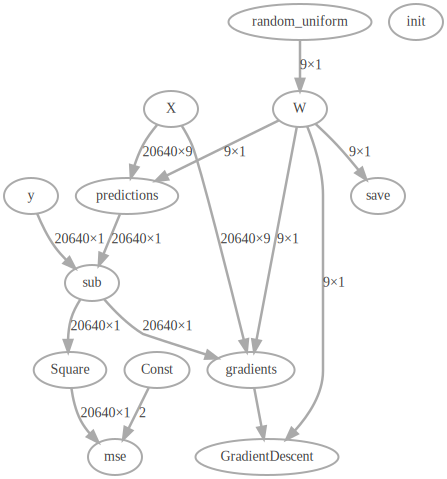

In [26]:
import tfgraphviz as tfg

tf_graph = tfg.board(tf.get_default_graph())
tf_graph